### **`Dependencies`**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import warnings

import pandas as pd
import plotly.express as px

from plotly.graph_objects import Figure

from src.data import fetch_data, transform_data
from src.inference import generate_multi_step_forecast
from src.model import compute_metrics, load_model
from src.monitor import backtest_model, evaluate_model
from src.utils import plot_time_series_splits

warnings.filterwarnings("ignore")

In [3]:
# set the pd.DataFrame and pd.Series display options
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 50)

### **`Feature pipeline`**

In [4]:
# raw data -> pre-processed and validated data -> features and targets
df: pd.DataFrame = fetch_data().pipe(transform_data)
df

2025-02-18 07:00:23.142 | INFO     | src.data:fetch_data:39 - Fetching raw data from the 'postgres' database's 'time_series.energy_demand' table.
2025-02-18 07:00:24.173 | INFO     | src.data:fetch_data:117 - The raw data has been pre-processed and validated.
2025-02-18 07:00:24.174 | INFO     | src.data:transform_data:233 - Transforming the pre-processed data into features and targets.


company_id       timestamp_utc  day_of_week  time_of_day  hour  \
0           aep 2025-02-05 15:00:00            3            1    15   
1           aep 2025-02-05 16:00:00            3            1    16   
2           aep 2025-02-05 17:00:00            3            2    17   
3           aep 2025-02-05 18:00:00            3            2    18   
4           aep 2025-02-05 19:00:00            3            2    19   
...         ...                 ...          ...          ...   ...   
3438       pjmw 2025-02-18 11:00:00            2            1    11   
3439       pjmw 2025-02-18 12:00:00            2            1    12   
3440       pjmw 2025-02-18 13:00:00            2            1    13   
3441       pjmw 2025-02-18 14:00:00            2            1    14   
3442       pjmw 2025-02-18 15:00:00            2            1    15   

      mean_24_lags  std_24_lags  mean_20_lags  std_20_lags  mean_16_lags  \
0     15153.375000  1309.433891      15000.40  1380.400262    14641.2500   
1     15112.541667  1306.826757      14896.75  1314.744277    14626.9375   
2     15093.250000  1301.739614      14822.15  1248.098523    14699.6250   
3     15054.083333  1292.560516      14748.45  1194.310569    14799.0000   
4     15015.583333  1261.919377      14731.30  1179.425377    14958.6250   
...            ...          ...           ...          ...           ...   
3438   4743.833333   349.082109       4655.55   312.015768     4595.1250   
3439   4728.250000   332.967455       4650.80   307.474535     4597.5000   
3440   4714.708333   317.588396       4650.35   307.063044     4599.1875   
3441   4702.333333   305.739541       4649.75   306.647385     4586.3750   
3442   4689.666667   294.688880       4648.15   305.756056     4568.3750   

      std_16_lags  mean_12_lags  std_12_lags  mean_8_lags  std_8_lags  \
0     1300.954649  14914.333333  1332.447600    15775.250  301.859357   
1     1298.565489  15078.250000  1151.495638    15645.500  479.609961   
2     1295.948809  15276.333333   906.940144    15511.375  425.748396   
3     1241.704098  15424.333333   623.510929    15373.750  424.661798   
4     1155.209122  15547.333333   455.113639    15321.875  363.477819   
...           ...           ...          ...          ...         ...   
3438   320.765517   4471.083333   263.510724     4432.125  269.948375   
3439   322.904114   4470.333333   262.200941     4515.500  296.746164   
3440   324.578541   4495.333333   289.881271     4604.875  295.128271   
3441   309.238177   4531.833333   305.062686     4683.500  258.552012   
3442   285.905316   4574.833333   302.540706     4743.625  212.107074   

      mean_4_lags  std_4_lags   lag_24   lag_23   lag_22   lag_21   lag_20  \
0        15552.25  188.287679  15703.0  15664.0  15835.0  16471.0  16796.0   
1        15291.00  397.684129  15664.0  15835.0  16471.0  16796.0  16693.0   
2        15189.75  337.800113  15835.0  16471.0  16796.0  16693.0  16369.0   
3        15033.75  272.919249  16471.0  16796.0  16693.0  16369.0  15890.0   
4        15091.50  362.341920  16796.0  16693.0  16369.0  15890.0  14952.0   
...           ...         ...      ...      ...      ...      ...      ...   
3438      4627.00  257.005837   5261.0   5238.0   5143.0   5099.0   4982.0   
3439      4767.25  179.327215   5238.0   5143.0   5099.0   4982.0   4922.0   
3440      4865.00   80.311892   5143.0   5099.0   4982.0   4922.0   4858.0   
3441      4890.00   31.885211   5099.0   4982.0   4922.0   4858.0   4827.0   
3442      4860.25   51.506472   4982.0   4922.0   4858.0   4827.0   4849.0   

       lag_19   lag_18   lag_17   lag_16   lag_15   lag_14   lag_13   lag_12  \
0     16693.0  16369.0  15890.0  14952.0  14038.0  13305.0  12993.0  12756.0   
1     16369.0  15890.0  14952.0  14038.0  13305.0  12993.0  12756.0  12824.0   
2     15890.0  14952.0  14038.0  13305.0  12993.0  12756.0  12824.0  13119.0   
3     14952.0  14038.0  13305.0  12993.0  12756.0  12824.0  13119.0  14071.0   
4     14038.0  13305.0  1

In [5]:
# line plot of each company ID's hourly energy demand
fig: Figure = px.line(
    data_frame=df,
    x="timestamp_utc",
    y="energy_demand_mw",
    color="company_id",
    labels={
        "timestamp_utc": "Timestamp (UTC)",
        "energy_demand_mw": "Energy Demand (MW)",
        "company_id": "Company ID"
    },
    markers=True,
    title="Hourly Energy Demand",
    template="plotly_dark"
)
fig.show()

### **`Training pipeline`**

2025-02-18 07:00:44.163 | INFO     | src.data:fetch_data:39 - Fetching raw data from the 'postgres' database's 'time_series.energy_demand' table.
2025-02-18 07:00:44.983 | INFO     | src.data:fetch_data:117 - The raw data has been pre-processed and validated.
2025-02-18 07:00:44.984 | INFO     | src.data:transform_data:233 - Transforming the pre-processed data into features and targets.


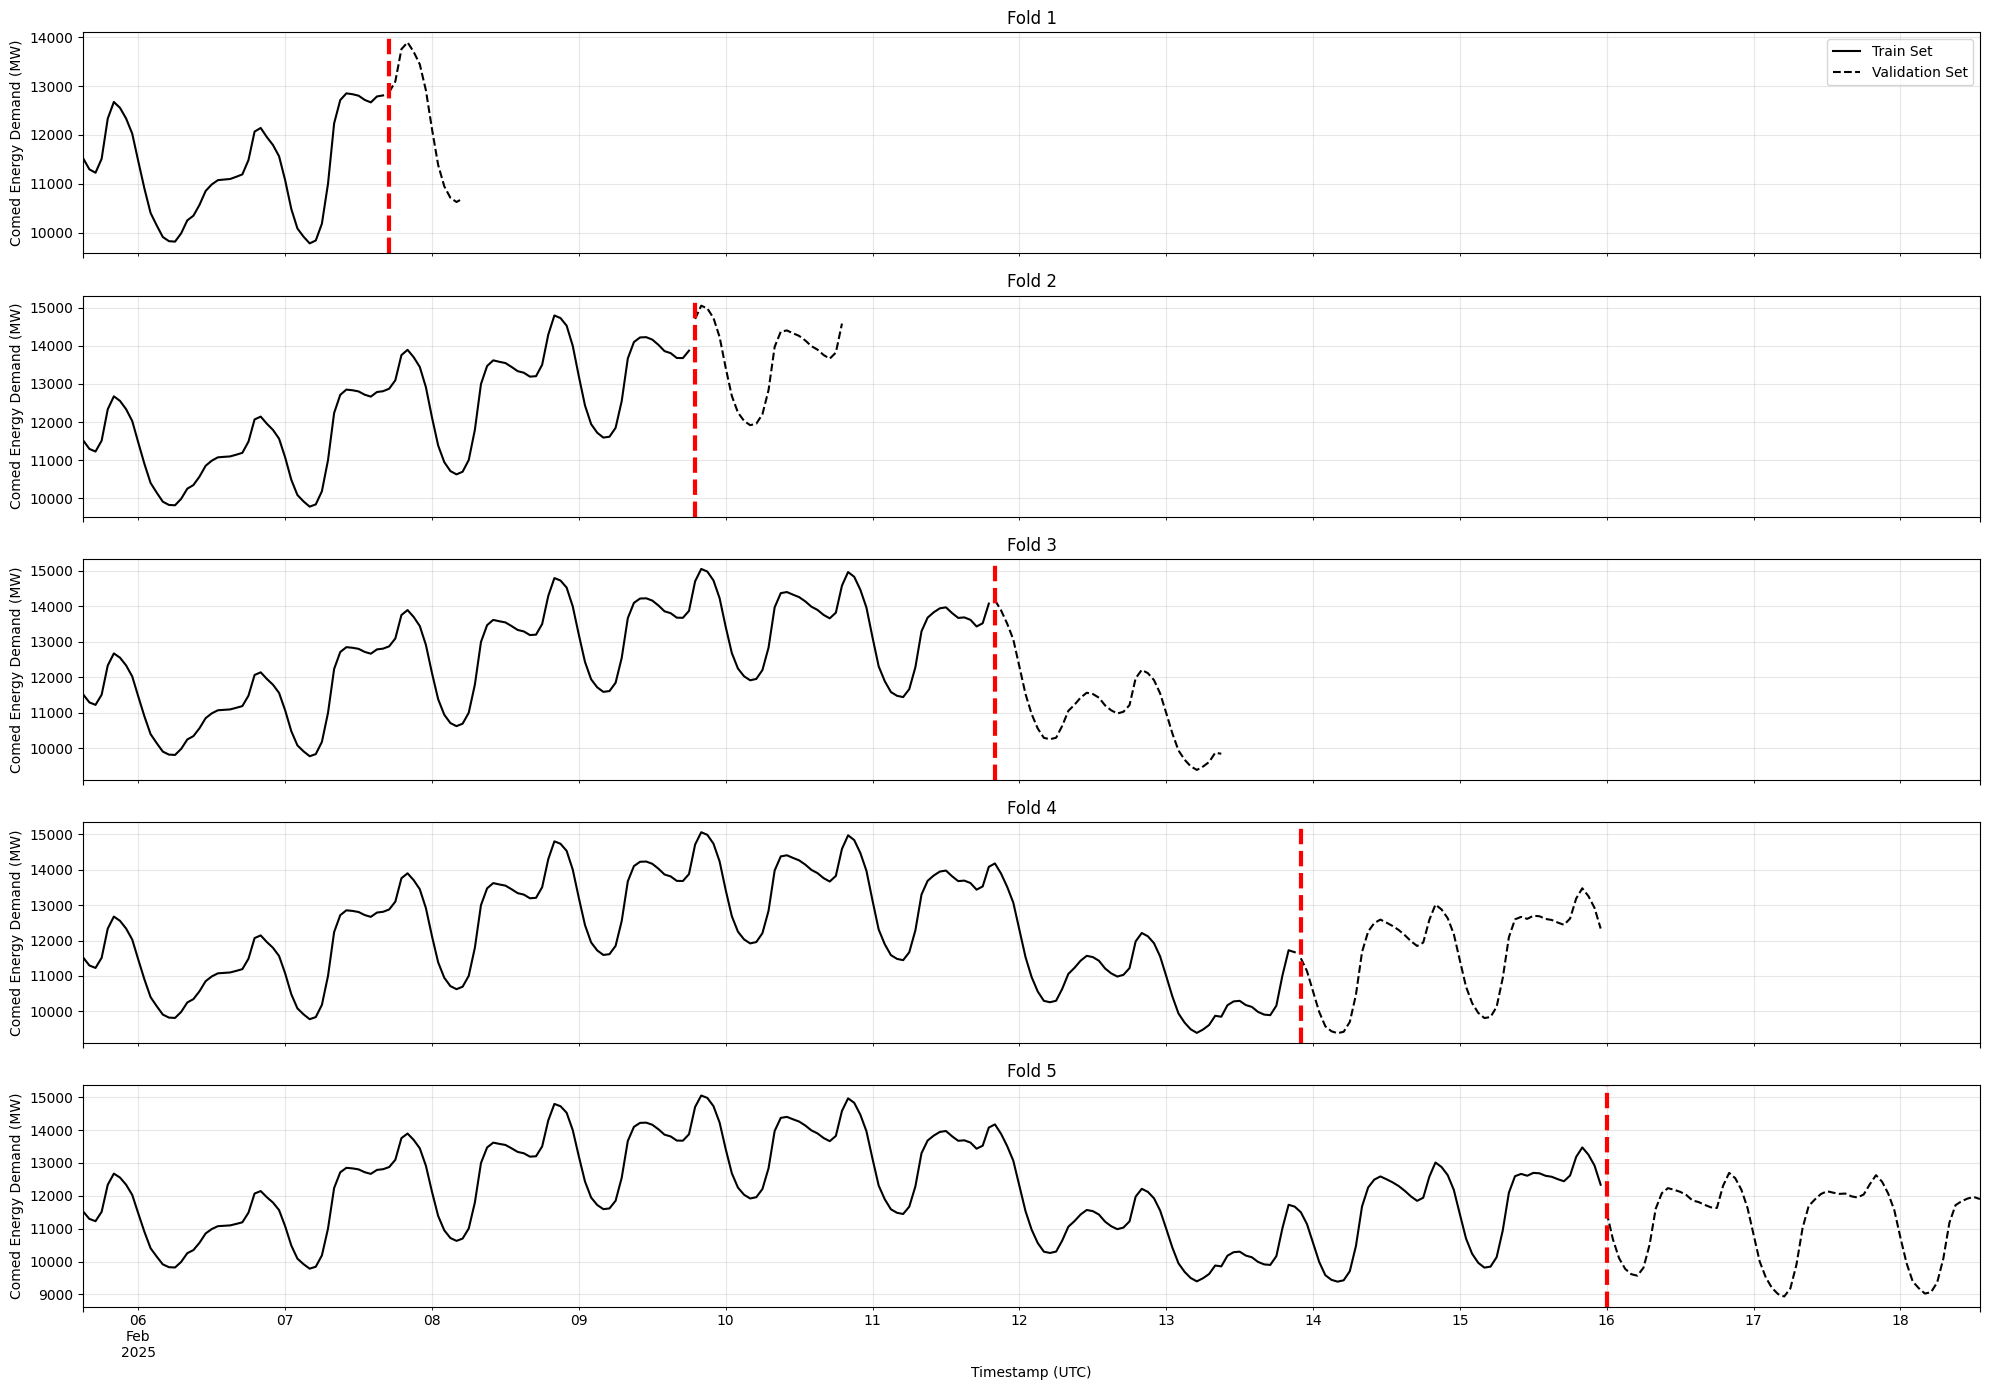

In [6]:
# plot the K-fold walk-forward validation for a randomly selected company ID
df: pd.DataFrame = fetch_data().pipe(transform_data)
df.pipe(
    plot_time_series_splits,
    random.choice(df["company_id"].unique())
)

In [7]:
# load the current forecasting model
load_model()

LGBMRegressor(learning_rate=0.17326859672437625, max_depth=8,
              min_data_in_leaf=21, n_estimators=148, num_leaves=43,
              verbosity=-1)

In [8]:
# backtest the current forecasting model
_, response = backtest_model(random.choice(range(4, 25)))
response

2025-02-18 07:01:01.431 | INFO     | src.data:fetch_data:39 - Fetching raw data from the 'postgres' database's 'time_series.energy_demand' table.
2025-02-18 07:01:02.257 | INFO     | src.data:fetch_data:117 - The raw data has been pre-processed and validated.
2025-02-18 07:01:02.258 | INFO     | src.data:transform_data:233 - Transforming the pre-processed data into features and targets.
2025-02-18 07:01:02.696 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 1 hour forecast.
2025-02-18 07:01:02.883 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 2 hour forecast.
2025-02-18 07:01:03.099 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 3 hour forecast.
2025-02-18 07:01:03.361 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 4 hour forecast.
2025-02-18 07:01:03.669 | INFO     | src.inference:generate_multi_step_forecast:15

'pass'

In [9]:
# evaluate the current forecasting model
evaluate_model()

2025-02-18 07:01:16.159 | INFO     | src.data:fetch_data:39 - Fetching raw data from the 'postgres' database's 'time_series.energy_demand' table.
2025-02-18 07:01:17.005 | INFO     | src.data:fetch_data:117 - The raw data has been pre-processed and validated.
2025-02-18 07:01:17.006 | INFO     | src.data:transform_data:233 - Transforming the pre-processed data into features and targets.
2025-02-18 07:01:17.467 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 1 hour forecast.
2025-02-18 07:01:17.629 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 2 hour forecast.
2025-02-18 07:01:17.840 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 3 hour forecast.
2025-02-18 07:01:18.096 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 4 hour forecast.
2025-02-18 07:01:18.400 | INFO     | src.inference:generate_multi_step_forecast:15

### **`Inference pipeline`**

In [10]:
df: pd.DataFrame = fetch_data().pipe(transform_data)

# a dictionary that maps each company ID to its split
horizon: int = 12
time_delta: pd.Timedelta = pd.Timedelta(hours=horizon)
splits: dict[str, pd.Timestamp] = {
    company_id: df.query(f"company_id == '{company_id}'")["timestamp_utc"].max() - time_delta
    for company_id in sorted(df["company_id"].unique())
}

# iterate over each company ID and create its train and test set
dfs: list[tuple[pd.DataFrame, pd.DataFrame]] = [
    (
        df.query(
            f"company_id == '{company_id}' & \
            timestamp_utc <= @pd.Timestamp('{split}')"
        ),
        df.query(
            f"company_id == '{company_id}' & \
            timestamp_utc > @pd.Timestamp('{split}')"
        )
    )
    for company_id, split in splits.items()
]

# vertically concatenate the train sets into a single train set; do the same for the test sets
df_train: pd.DataFrame = pd.concat([tup[0] for tup in dfs], axis=0, ignore_index=True)
df_test: pd.DataFrame = pd.concat([tup[1] for tup in dfs], axis=0, ignore_index=True)

2025-02-18 07:01:31.444 | INFO     | src.data:fetch_data:39 - Fetching raw data from the 'postgres' database's 'time_series.energy_demand' table.
2025-02-18 07:01:32.258 | INFO     | src.data:fetch_data:117 - The raw data has been pre-processed and validated.
2025-02-18 07:01:32.260 | INFO     | src.data:transform_data:233 - Transforming the pre-processed data into features and targets.


In [11]:
# a dictionary to map each company ID to its last known value, i.e., the train set's last value
naive_forecaster: dict[str, float] = {
    company_id: (
        df_train
        .query(f"company_id == '{company_id}' & timestamp_utc == @pd.Timestamp('{split}')")
        ["energy_demand_mw"]
        .squeeze()
    )
    for company_id, split in splits.items()
}
naive_forecaster

{'aep': 12660.0,
 'comed': 9186.0,
 'dayton': 1577.0,
 'deok': 2598.0,
 'dom': 7388.0,
 'duq': 1504.0,
 'ekpc': 1268.0,
 'fe': 7756.0,
 'ni': 9835.0,
 'pjme': 26083.0,
 'pjmw': 4220.0}

In [12]:
# a pd.DataFrame that contains the target, the naive forecast, and the model's forecast
df_forecast: pd.DataFrame = (
    df_test
    .assign(naive_forecast=df_test["company_id"].map(naive_forecaster))
    .merge(
        df_train.pipe(generate_multi_step_forecast, forecast_horizon=horizon),
        how="inner",
        on=["company_id", "timestamp_utc"]
    )
    .rename(columns={"energy_demand_mw": "target", "forecast": "model_forecast"})
    [[
        "company_id",
        "timestamp_utc",
        "target",
        "naive_forecast",
        "model_forecast"
    ]]
)
df_forecast

2025-02-18 07:02:34.874 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 12 hour forecast.


company_id       timestamp_utc   target  naive_forecast  model_forecast
0          aep 2025-02-18 04:00:00  12555.0         12660.0         12786.0
1          aep 2025-02-18 05:00:00  12811.0         12660.0         13047.0
2          aep 2025-02-18 06:00:00  13625.0         12660.0         13851.0
3          aep 2025-02-18 07:00:00  15270.0         12660.0         15233.0
4          aep 2025-02-18 08:00:00  16160.0         12660.0         15724.0
..         ...                 ...      ...             ...             ...
127       pjmw 2025-02-18 11:00:00   4887.0          4220.0          5136.0
128       pjmw 2025-02-18 12:00:00   4913.0          4220.0          5136.0
129       pjmw 2025-02-18 13:00:00   4846.0          4220.0          5140.0
130       pjmw 2025-02-18 14:00:00   4795.0          4220.0          5068.0
131       pjmw 2025-02-18 15:00:00   4722.0          4220.0          5054.0

[132 rows x 5 columns]

In [13]:
# compare the naive forecast to the model's forecast
y: pd.Series = df_forecast["target"]
naive_metric: float = compute_metrics(y, df_forecast["naive_forecast"]).get("r_squared")
model_metric: float = compute_metrics(y, df_forecast["model_forecast"]).get("r_squared")
print(f"{horizon}-Hour Forecast\nNaive R²: {naive_metric}\nModel R²: {model_metric}")

12-Hour Forecast
Naive R²: 0.9089
Model R²: 0.9886


In [15]:
# plot the target, the naive forecast, and the model's forecast for each company ID
figs: list[Figure] = [
    px.line(
        (
            df_forecast
            .query(f"company_id == '{company_id}'")
            .rename(columns={
                "target": "Target",
                "model_forecast": "Model Forecast",
                "naive_forecast": "Naive Forecast"
            })
        ),
        x="timestamp_utc",
        y=["Target", "Model Forecast", "Naive Forecast"],
        color_discrete_sequence=["green", "blue", "red"],
        labels={
            "timestamp_utc": "Timestamp (UTC)",
            "value": "Energy Demand (MW)",
            "variable": "Company ID"
        },
        markers=True,
        title=f"{company_id.title()} Hourly Energy Demand",
        template="plotly_dark"
    )
    for company_id in sorted(df_forecast["company_id"].unique())
]
_ = [fig.show() for fig in figs]

In [ ]:
# a class that encapsulates the energy demand forecasting pipeline
class ForecastingPipeline:
    def __init__(self, forecast_horizon: int):
        self.forecast_horizon: int = forecast_horizon
    
    def __str__(self):
        return f"{self.forecast_horizon}-hour forecast"

    def run(self) -> pd.DataFrame:
        return (
            fetch_data()
            .pipe(transform_data)
            .pipe(generate_multi_step_forecast, self.forecast_horizon)
        )

# instantiate an object of tyep, 'ForecastingPipeline'
fp: ForecastingPipeline = ForecastingPipeline(horizon)
display(
    fp.forecast_horizon, fp.__str__(), fp.run()
)